In [1]:
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver

wd.get("https://rinatius.github.io/4magnets/")
element.send_keys(str(int(value)))
element.click()
wd.find_element_by_xpath("/html/body/input[2]")
element.get_attribute("value")


In [2]:
from IPython.display import Image
from selenium.webdriver.common.keys import Keys
import numpy as np
import time

In [3]:
import keras
from keras.layers import Dense, Flatten, Dropout, MaxPooling1D, Conv1D, Input, LSTM, SimpleRNN, Reshape
from keras.models import Model
from keras.layers.merge import concatenate
from keras.utils import Sequence
from keras import backend as K
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [7]:
#wd = webdriver.Chrome()
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
wd = webdriver.Chrome('chromedriver', options=chrome_options)

In [8]:
wd.get("https://rinatius.github.io/4magnets/")

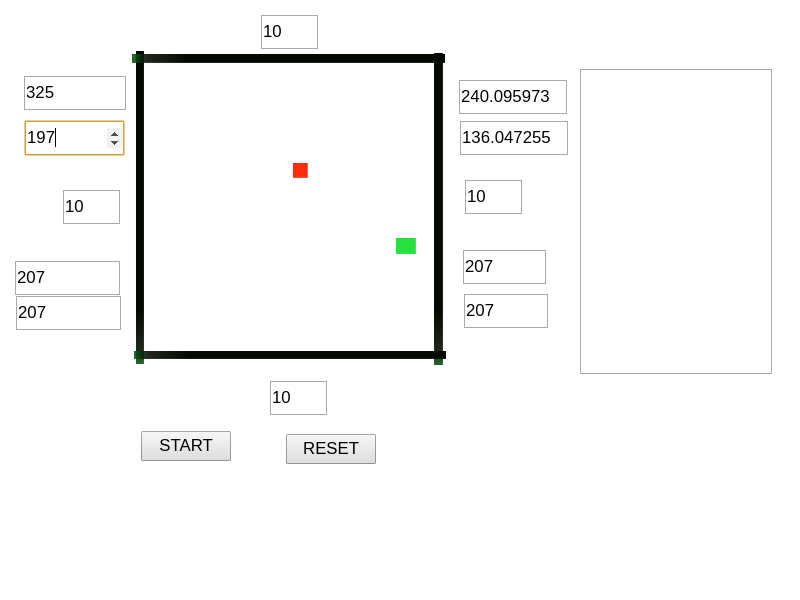

In [27]:
Image(wd.get_screenshot_as_png())

In [11]:
X_MIN = 120
X_MAX = 340
Y_MIN = 56
Y_MAX = 273
multiplier = 100

def write_value(value, element):
    select_all_symbols(element)
    element.send_keys(str(int(value)))

def select_all_symbols(element):
    element.click()
    element.send_keys(Keys.END)
    element.send_keys(Keys.SHIFT + Keys.HOME)

def get_state(wd):
    values = []
    values.append((float(wd.find_element_by_xpath("/html/body/input[2]").get_attribute("value")) - X_MIN)/(X_MAX - X_MIN))
    values.append((float(wd.find_element_by_xpath("/html/body/input[3]").get_attribute("value")) - Y_MIN)/(Y_MAX - Y_MIN))
    values.append((float(wd.find_element_by_xpath("/html/body/input[4]").get_attribute("value")) - X_MIN)/(X_MAX - X_MIN))
    values.append((float(wd.find_element_by_xpath("/html/body/input[5]").get_attribute("value")) - Y_MIN)/(Y_MAX - Y_MIN))
    return np.array(values).reshape(1, len(values))

def act(wd, actions, multiplier=multiplier):
    left = wd.find_element_by_xpath("/html/body/input[1]")
    right = wd.find_element_by_xpath("/html/body/input[6]")
    top = wd.find_element_by_xpath("/html/body/input[7]")
    bottom = wd.find_element_by_xpath("/html/body/input[8]")
    
    write_value(actions[0]*multiplier, left)
    write_value(actions[1]*multiplier, right)
    write_value(actions[2]*multiplier, top)
    write_value(actions[3]*multiplier, bottom)

def randomize_element(wd, x_el, y_el):
    x_element = wd.find_element_by_xpath("/html/body/input["+x_el+"]")
    y_element = wd.find_element_by_xpath("/html/body/input["+y_el+"]")
    x = int(np.random.rand() * (X_MAX - X_MIN) + X_MIN)
    y = int(np.random.rand() * (Y_MAX - Y_MIN) + Y_MIN)
    write_value(x, x_element)
    write_value(y, y_element)

def random_target(wd):
    randomize_element(wd, '2', '3')
    
def random_position(wd):
    randomize_element(wd, '13', '14')
    
def show_prediction(wd, xy):
    x = wd.find_element_by_xpath("/html/body/input[9]")
    y = wd.find_element_by_xpath("/html/body/input[10]")
    
    write_value(int(xy[0] * (X_MAX - X_MIN) + X_MIN), x)
    write_value(int(xy[1] * (Y_MAX - Y_MIN) + Y_MIN), y)
    
def start_sim(wd):
    wd.find_element_by_xpath("/html/body/input[12]").click()
    
def reset_sim(wd):
    wd.find_element_by_xpath("/html/body/input[15]").click()
    

In [12]:
state_len = get_state(wd).shape[1]
num_commands = 4
sequence_len = 3
batch_size = 10
batches = 10
epochs = 50
dropout = 0.2
empty = -1
conv_input_shape = (sequence_len, num_commands)

In [13]:
def control_reproduction_loss(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true))

'''def prediction_loss(y_true, y_pred):
    prediction_accuracy = K.mean(K.sum(K.square(y_pred - y_true[:, 3])))
    square_distance_to_target = K.mean(K.sum(K.square(y_pred - y_true[:, 0])))
    combined_loss = K.exp(K.sqrt(prediction_accuracy))*K.sqrt(square_distance_to_target)
    return combined_loss'''

def prediction_loss(y_true, y_pred):
    prediction_accuracy = K.mean(K.sum(K.square(y_pred - y_true[:, 3, :])))
    #square_distance_to_target = K.mean(K.sum(K.square(y_pred - y_true[:, 0])))
    combined_loss = prediction_accuracy
    return combined_loss

def prediction_accuracy(y_true, y_pred):
    return K.mean(K.sum(K.square(y_pred - y_true[:, 3, :])))

def distance_to_target(y_true, y_pred):
    return K.mean(K.sum(K.square(y_true[:, 0] - y_true[:, 3, :])))

def predicted_distance_to_target(y_true, y_pred):
    return K.mean(K.sum(K.square(y_pred - y_true[:, 0, :])))

def prediction_reproduction(y_true, y_pred):
    return K.mean(K.sum(K.square(y_pred - y_true[:, 4, :])))

'''def prediction_loss(y_true, y_pred):
    prediction_accuracy = K.mean(K.sum(K.square(y_pred)))
    #square_distance_to_target = K.mean(K.sum(K.square(y_pred - y_true[:, 0])))
    combined_loss = prediction_accuracy
    return combined_loss'''

'def prediction_loss(y_true, y_pred):\n    prediction_accuracy = K.mean(K.sum(K.square(y_pred)))\n    #square_distance_to_target = K.mean(K.sum(K.square(y_pred - y_true[:, 0])))\n    combined_loss = prediction_accuracy\n    return combined_loss'

In [38]:
class WDSequence(Sequence):

    def __init__(self,
                 wd,
                 model,
                 batches,
                 batch_size):
        self.model = model
        self.wd = wd
        self.batches = batches
        self.batch_size = batch_size

    def __len__(self):
        return self.batches

    def __getitem__(self, idx):
        
        reset_sim(self.wd)
        time.sleep(1)
        random_target(self.wd)
        random_position(self.wd)
        start_sim(self.wd)
        state = np.full([sequence_len, state_len], get_state(self.wd))
        
        in_state = []
        out_control = []
        out_prediction = []
        
        for i in range(batch_size):  

            state = np.append(state[1:], get_state(self.wd), axis=0)


            target = state[-1, :2]
            position = state[-1, 2:]


            y_pred = self.model.predict(state.reshape([1, state.shape[0], state.shape[1]]))
            actions = y_pred[0][0]

            act(wd, actions)
            show_prediction(wd, y_pred[1][0][0])
            time.sleep(0.3)

            new_state = get_state(self.wd)
            new_target = new_state[0][:2]
            new_position = new_state[0][2:]

            predicted_position = y_pred[1][0][0]

            in_state.append(state)
            out_control.append(y_pred[0][0][0])
            out_prediction.append([target, position, new_target, new_position, predicted_position])
            #out_prediction.append(new_position)
        
        return ({'in_state': np.array(in_state)}, 
                {'out_control': np.array(out_control), 
                 'out_prediction': np.array(out_prediction)} )

In [39]:
#input_shape = [1, 8]

In [40]:
#in_state = LSTM(4, input_shape=(None, 1, 4), return_sequences=True, name='in_state')
in_state = Input(shape=(None, 4), name='in_state')
first_lstm = LSTM(128, return_sequences=True, name='first_lstm')(in_state)
l = LSTM(128)(first_lstm)
l = Dense(128, activation='relu')(l)
out_control = Dense(num_commands, activation='sigmoid', name='out_control')(l)
last_lstm = LSTM(128, name='last_lstm')(first_lstm)
l = concatenate([last_lstm, out_control])
l = Dense(128, activation='relu')(l)
l = Dense(2, activation='sigmoid')(l)
out_prediction = Reshape((1, 2), name='out_prediction')(l)

In [41]:
model = Model(inputs=[in_state],
              outputs=[out_control, out_prediction])
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
in_state (InputLayer)           (None, None, 4)      0                                            
__________________________________________________________________________________________________
first_lstm (LSTM)               (None, None, 128)    68096       in_state[0][0]                   
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 128)          131584      first_lstm[0][0]                 
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 128)          16512       lstm_3[0][0]                     
__________________________________________________________________________________________________
out_contro

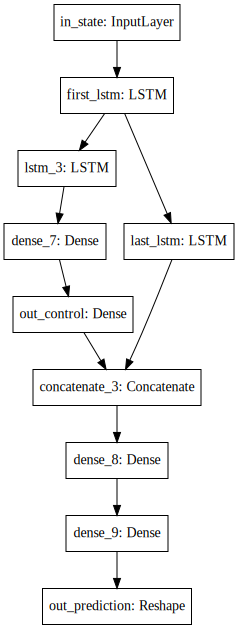

In [42]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [43]:
model.compile(loss={'out_control': control_reproduction_loss,
                    'out_prediction': prediction_loss},
              loss_weights={'out_control': 0,
                            'out_prediction': 1},
              optimizer=keras.optimizers.Adam(),
              metrics={'out_prediction': [prediction_accuracy,
                                          distance_to_target, 
                                          predicted_distance_to_target,
                                          prediction_reproduction]})

In [44]:
model.load_weights('rnn_68epochs.h5')

In [45]:
sequence = WDSequence(wd, model, batches=batches, batch_size=batch_size)

In [46]:
state = np.full([sequence_len, num_commands], empty)
state = np.append(state[1:], get_state(wd), axis=0)
model.predict(state.reshape(1, state.shape[0], state.shape[1]))[1][0][0]

array([0.12861812, 0.08848354], dtype=float32)

In [47]:
model.fit_generator(sequence, epochs=epochs, verbose=1)

Epoch 1/50
10/10 [==============================] - 187s 19s/step - loss: 2.5927 - out_control_loss: 0.0160 - out_prediction_loss: 2.5927 - out_prediction_prediction_accuracy: 2.5927 - out_prediction_distance_to_target: 4.8562 - out_prediction_predicted_distance_to_target: 45.5337 - out_prediction_prediction_reproduction: 1.4094
Epoch 2/50
10/10 [==============================] - 194s 19s/step - loss: 3.3373 - out_control_loss: 0.0161 - out_prediction_loss: 3.3373 - out_prediction_prediction_accuracy: 3.3373 - out_prediction_distance_to_target: 3.3012 - out_prediction_predicted_distance_to_target: 29.5703 - out_prediction_prediction_reproduction: 2.3707
Epoch 3/50
10/10 [==============================] - 198s 20s/step - loss: 2.9313 - out_control_loss: 0.0191 - out_prediction_loss: 2.9313 - out_prediction_prediction_accuracy: 2.9313 - out_prediction_distance_to_target: 3.6470 - out_prediction_predicted_distance_to_target: 31.7648 - out_prediction_prediction_reproduction: 2.1191
Epoch 4

KeyboardInterrupt: 

In [48]:
model.save_weights('rnn_86epochs.h5')

In [ ]:
model.predict(np.array([get_state(wd)]))[1][0][0]

In [ ]:
[get_state(wd)].shape

In [ ]:
test = np.random.rand(3, 5, 2)

In [ ]:
test

In [ ]:
test[:, 3, :]

In [ ]:
test.reshape([3, 1, 5])[:, :, 0]

In [ ]:
in_state = []
state = get_state(wd)

In [ ]:
state

In [ ]:
in_state.append(state)

In [ ]:
in_state

In [ ]:
np.array(in_state)

In [ ]:
state1 = get_state(wd)

In [ ]:
state2 = get_state(wd)

In [ ]:
np.append(state1, state2).reshape([1, 8])

In [ ]:
state1.shape

In [ ]:
model.predict(get_state(wd).reshape([1, 1, 4]))[0]

In [ ]:
s = get_state(wd)

In [ ]:
state_h = get_state(wd)

In [ ]:
state_h = np.append(state_h, s, axis=0)

In [ ]:
model.predict(state_h.reshape([1, state_h.shape[0], state_h.shape[1]]))[0][0].shape

In [ ]:
state_h

In [ ]:
form = np.full([sequence_len, state_len], empty)

In [ ]:
form

In [ ]:
form = np.append(form[1:], get_state(wd), axis=0)

In [ ]:
form

In [ ]:
form = np.append(form[1:], get_state(wd),  axis=0)

In [ ]:
model.predict(form.reshape([1, form.shape[0], form.shape[1]]))

In [ ]:
get_state(wd)

In [ ]:
form

In [ ]:
form[-1, 2:]

In [ ]:
np.full([sequence_len, state_len], empty)

In [ ]:
example = np.full([6, 4], 0)

In [ ]:
example = np.append(example[1:], get_state(wd), axis=0)

In [ ]:
example

In [24]:
start_sim(wd)

In [25]:
random_target(wd)

In [ ]:
wd.get("https://rinatius.github.io/4magnets/") element.send_keys(str(int(value))) element.click() wd.find_element_by_xpath("/html/body/input[2]") element.get_attribute("value")


In [49]:
class MultiWD():
    def __init__(self, wd_number):
        chrome_options = webdriver.ChromeOptions()
        chrome_options.add_argument('--headless')
        self.drivers = []
        for i in range(wd_number):
            self.drivers.append(webdriver.Chrome('chromedriver', options=chrome_options))
            
    def get(self, url):
        for driver in self.drivers:
            driver.get(url)
    
    def find_element_by_xpath(self, xpath):
        return MultiElement([driver.find_element_by_xpath(xpath) for driver in self.drivers])

class MultiElement():
    def __init__(self, elements):
        self.elements = elements
    
    def send_keys(self, value):
        return [element.send_keys(value) for element in self.elements]
    
    def click(self):
        for element in self.elements:
            element.click()
    
    def get_attribute(self, attribute):
        return [float(element.get_attribute(attribute)) for element in self.elements]
        
    

In [50]:
mwd = MultiWD(3)

In [51]:
mwd.get("https://rinatius.github.io/4magnets/")

In [52]:
get_state(mwd)

TypeError: float() argument must be a string or a number, not 'list'

In [54]:
float(np.zeros([3, 2]))

TypeError: only size-1 arrays can be converted to Python scalars